<a href="https://colab.research.google.com/github/Divyanshyadavofficial/RNN/blob/main/Sequences_and_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
assert sys.version_info>=(3,5)

IS_COLAB = "goggle.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import sklearn
assert sklearn.__version__>="0.20"

import tensorflow as tf
from tensorflow import keras
assert tf.__version__>="2.0"

if not tf.config.list_physical_devices('GPU'):
  print("No GPU was detected.")
  if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
  if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")
import numpy as np
import os
from pathlib import Path

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID)
os.makedirs(IMAGES_PATH,exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected.


### Basic RNN's

#### Generate the dataset

In [2]:
def generate_time_series(batch_size,n_steps):
  freq1,freq2,offset1,offset2 = np.random.rand(4,batch_size,1)
  time = np.linspace(0,1,n_steps)
  series = 0.5 * np.sin((time - offset1) * (freq1*10+10))
  series += 0.2 * np.sin((time-offset2)*(freq2*20+20))
  series += 0.1 *(np.random.rand(batch_size,n_steps)-0.5)
  return series[...,np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps=50
series = generate_time_series(10000,n_steps+1)
X_train,y_train = series[:7000,:n_steps],series[:7000,-1]
X_valid,y_valid = series[7000:9000,:n_steps],series[7000:9000,-1]
X_test,y_test = series[9000:,:n_steps],series[9000:,-1]

In [4]:
X_train.shape,y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure timeseries_plot


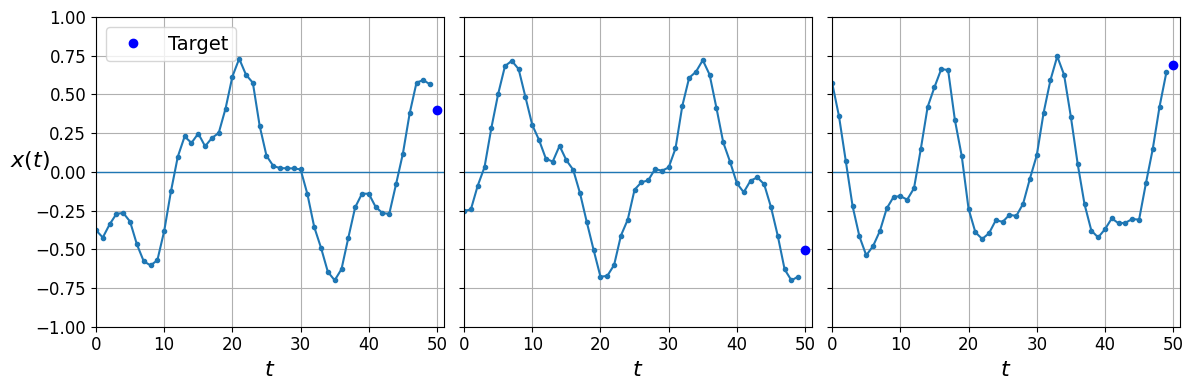

In [5]:
def plot_series(series,y=None,y_pred=None,x_label="$t$",y_label="$x(t)$",legend=True):
  plt.plot(series,".-")
  if y is not None:
    plt.plot(n_steps,y,"bo",label="Target")
  if y_pred is not None:
    plt.plot(n_steps,y_pred,"rx",markersize=10,label="Prediction")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.hlines(0,0,100,linewidth=1)
  plt.axis([0,n_steps+1,-1,1])
  if legend and (y or y_pred):
    plt.legend(fontsize=14,loc="upper left")

fig,axes = plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(12,4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col,:,0],y_valid[col,0],
              y_label=("$x(t)$"if col==0 else None),
              legend=(col==0))
save_fig("timeseries_plot")
plt.show()

### Computing base lines

Naive predicictions(just predict the last observed value):



In [6]:
y_pred = X_valid[:, -1]
mse = tf.keras.losses.MeanSquaredError()
loss_value = mse(y_valid, y_pred).numpy()
print(loss_value)

0.020211365


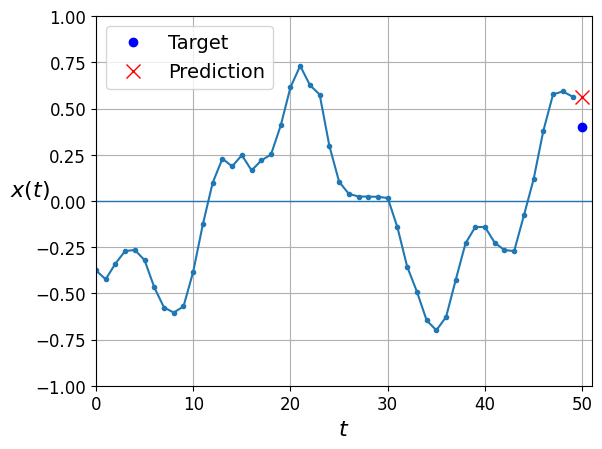

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Linear predictions

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1804 - val_loss: 0.0528
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0395 - val_loss: 0.0183
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157 - val_loss: 0.0106
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - val_loss: 0.0082
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [9]:
model.evaluate(X_valid,y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037


0.0037369190249592066

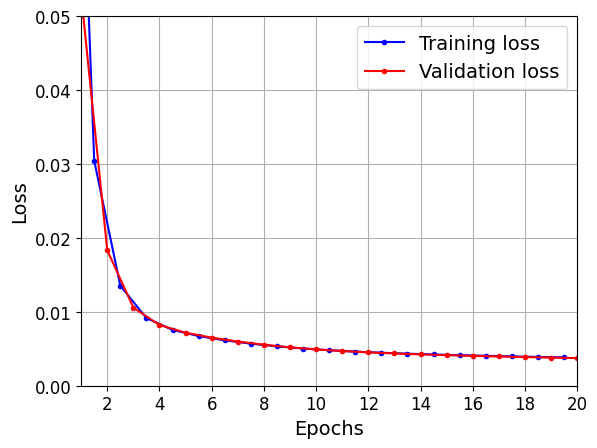

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


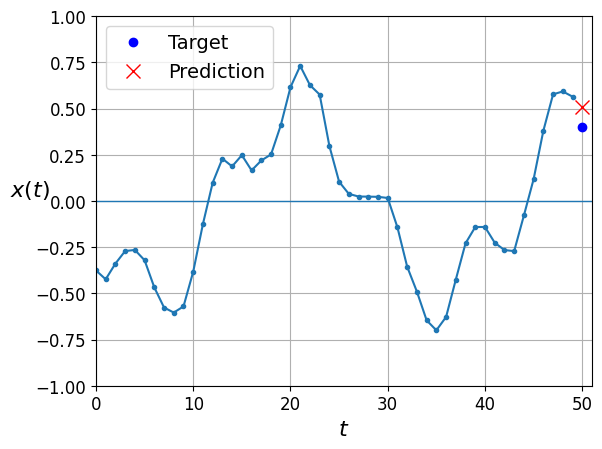

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

### Using simple Rnn

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1,input_shape=[None,1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse",optimizer=optimizer)
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_valid,y_valid))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1338 - val_loss: 0.0474
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0389 - val_loss: 0.0258
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0237 - val_loss: 0.0187
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0179 - val_loss: 0.0152
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0150 - val_loss: 0.0132
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0132 - val_loss: 0.0120
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0123 - val_loss: 0.0114
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0

In [13]:
model.evaluate(X_valid,y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110


0.010911310091614723

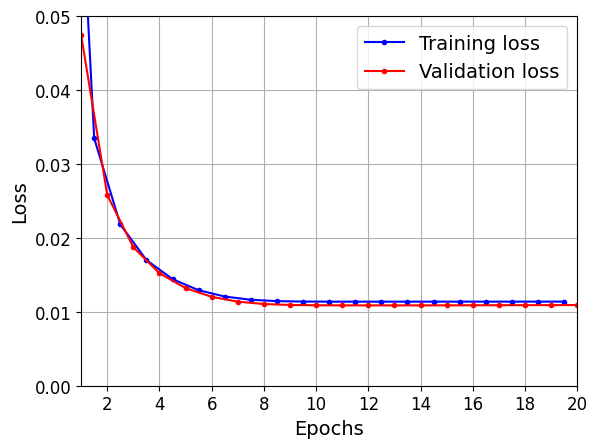

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


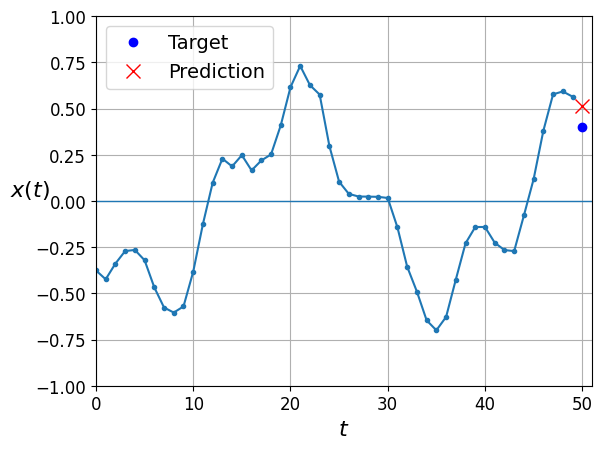

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Deep RNNs

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse",optimizer="adam")
history = model.fit(X_train,y_train,epochs=20,
                    validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.0618 - val_loss: 0.0050
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse",optimizer="adam")
history = model.fit(X_train,y_train,epochs=20,
                    validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1115 - val_loss: 0.0055
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [18]:
model.evaluate(X_valid,y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026


0.0027354329358786345

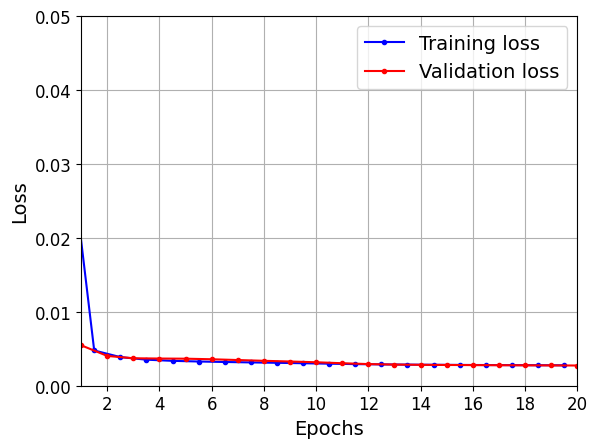

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


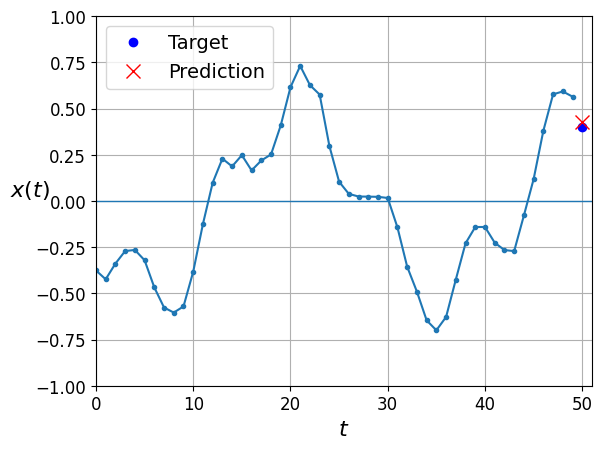

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [21]:
np.random.seed(43)

series = generate_time_series(1,n_steps+10)
X_new,Y_new = series[:,:n_steps],series[:,n_steps:]
X = X_new
for step_ahead in range(10):
  y_pred_one = model.predict(X[:,step_ahead:])[:,np.newaxis,:]
  X = np.concatenate([X,y_pred_one],axis=1)

Y_pred = X[:,n_steps:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [22]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


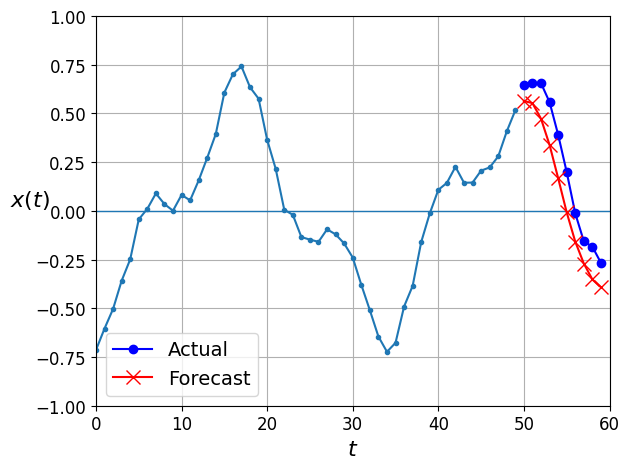

In [23]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values.We first need to regenerate the sequences with 9 more time steps

In [24]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000,n_steps+10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [25]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [26]:
Y_pred.shape

(2000, 10)

In [27]:
mse = tf.keras.losses.MeanSquaredError()
loss_value = mse(Y_valid, Y_pred).numpy()
print(loss_value)

0.026585713


Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [28]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
mse = tf.keras.losses.MeanSquaredError()
loss_value = mse(Y_naive_pred, Y_pred).numpy()
print(loss_value)

0.2886328


In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse",optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2558 - val_loss: 0.0769
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0668 - val_loss: 0.0477
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0445 - val_loss: 0.0368
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356 - val_loss: 0.0317
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0311 - val_loss: 0.0287
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0283 - val_loss: 0.0267
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264 - val_loss: 0.0252
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250 - val_loss: 0.0241
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239 - val_loss: 0.0233
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231 - val_loss: 0.0226
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0223 - val_loss: 0.0220
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Now let's create an RNN that predicts all 10 next values at once

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.1658 - val_loss: 0.0359
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0331 - val_loss: 0.0280
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0257 - val_loss: 0.0228
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0213 - val_loss: 0.0188
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0179 - val_loss: 0.0155
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0154 - val_loss: 0.0137
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0137 - val_loss: 0.0123
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0122 - val_loss: 0.0113
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0111 - val_loss: 0.0099
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0108 - val_loss: 0.0093
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [31]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


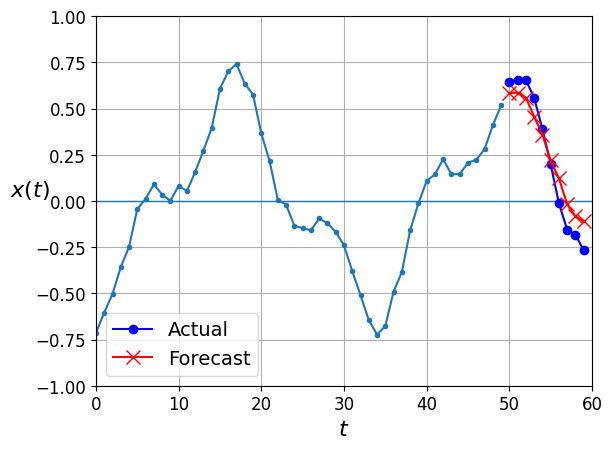

In [32]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [33]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000,n_steps+10)
X_train = series[:7000,:n_steps]
X_valid = series[7000:9000,:n_steps]
X_test = series[9000:,:n_steps]
Y = np.empty([10000,n_steps,10])
for step_ahead in range(1,10+1):
  Y[...,step_ahead-1] = series[...,step_ahead:step_ahead+n_steps,0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [34]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


mse = tf.keras.losses.MeanSquaredError()

def last_time_step_mse(Y_true, Y_pred):
    return mse(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - last_time_step_mse: 0.0721 - loss: 0.0771 - val_last_time_step_mse: 0.0275 - val_loss: 0.0406
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - last_time_step_mse: 0.0261 - loss: 0.0390 - val_last_time_step_mse: 0.0193 - val_loss: 0.0326
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - last_time_step_mse: 0.0193 - loss: 0.0324 - val_last_time_step_mse: 0.0142 - val_loss: 0.0280
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - last_time_step_mse: 0.0162 - loss: 0.0291 - val_last_time_step_mse: 0.0139 - val_loss: 0.0263
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - last_time_step_mse: 0.0149 - loss: 0.0274 - val_last_time_step_mse: 0.0138 - val_loss: 0.0253
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - last_time_step_mse: 0.0113 - loss: 0.0244 - val_last_time_step_mse: 0.0106 - val_loss: 0.0225
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - last_time_step_mse: 0.0099 - loss: 0.0226 - val_l

In [36]:
np.random.seed(43)
series = generate_time_series(1,50+10)
X_new, Y_new = series[:,:50,:],series[:,50:, :]
Y_pred = model.predict(X_new)[:,-1][...,np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


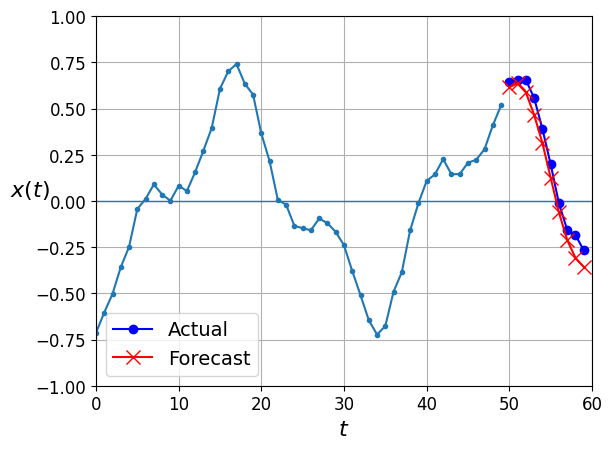

In [37]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

### Deep RNN with Batch Norm

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20,return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train,epochs=20,
                    validation_data = [X_valid,Y_valid])

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - last_time_step_mse: 0.4961 - loss: 0.5010 - val_last_time_step_mse: 0.0936 - val_loss: 0.0990
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - last_time_step_mse: 0.0524 - loss: 0.0619 - val_last_time_step_mse: 0.0482 - val_loss: 0.0581
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - last_time_step_mse: 0.0407 - loss: 0.0507 - val_last_time_step_mse: 0.0365 - val_loss: 0.0481
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - last_time_step_mse: 0.0345 - loss: 0.0456 - val_last_time_step_mse: 0.0310 - val_loss: 0.0437
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - last_time_step_mse: 0.0297 - loss: 0.0420 - val_last_time_step_mse: 0.0276 - val_loss: 0.0407
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - last_time_step_mse: 0.0262 - loss: 0.0393 - val_last_time_step_mse: 0.0244 - val_loss: 0.0386
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - last_time_step_mse: 0.0241 - loss: 0.0375 - val_la

### Deep RNNs with layer Norm

In [39]:
from tensorflow.keras.layers import LayerNormalization

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        # Ensure the internal SimpleRNNCell is properly built
        self.simple_rnn_cell.build(input_shape)
        self.layer_norm.build((None, self.state_size))
        self.built = True

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        # Robust handling for both build and training phases
        if batch_size is None:
            if inputs is not None:
                batch_size = tf.shape(inputs)[0]
            else:
                batch_size = 1  # Fallback to 1 to avoid None errors

        if dtype is None:
            dtype = tf.float32  # Default dtype

        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [41]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train,epochs=20,
                    validation_data=[X_valid,Y_valid])

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - last_time_step_mse: 0.2556 - loss: 0.2821 - val_last_time_step_mse: 0.0644 - val_loss: 0.0734
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - last_time_step_mse: 0.0604 - loss: 0.0685 - val_last_time_step_mse: 0.0453 - val_loss: 0.0575
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - last_time_step_mse: 0.0447 - loss: 0.0550 - val_last_time_step_mse: 0.0363 - val_loss: 0.0487
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - last_time_step_mse: 0.0365 - loss: 0.0473 - val_last_time_step_mse: 0.0302 - val_loss: 0.0429
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - last_time_step_mse: 0.0311 - loss: 0.0422 - val_last_time_step_mse: 0.0253 - val_loss: 0.0390
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - last_time_step_mse: 0.0263 - loss: 0.0385 - val_last_time_step_mse: 0.0221 - val_loss: 0.0364
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - last_time_step_mse: 0.0233 - loss: 0.0361 - v

### Creating a Custom RNN Class

In [42]:
class MyRNN(keras.layers.Layer):
  def __init__(self,cell,return_sequences=False,**kwargs):
    super().__init__(**kwargs)
    self.cell = cell
    self.return_sequences = return_sequences
    self.get_initial_state = getattr(
        self.cell,"get_initial_state",self.fallback_initial_state
    )
  def fallback_initial_state(self,inputs):
    batch_size = tf.shape(inputs)[0]
    return [tf.zeros([batch_size,self.cell.state_size],dtype=inputs.dtype)]
  @tf.function
  def call(self,inputs):
    states = self.get_initial_state(inputs)
    shape = tf.shape(inputs)
    batch_size = shape[0]
    n_steps = shape[1]
    sequences = tf.TensorArray(
        inputs.dtype,size=(n_steps if self.return_sequences else 0)
    )
    outputs = tf.zeros(shape=[batch_size,self.cell.output_size],dtype=inputs.dtype)
    for step in tf.range(n_steps):
      outputs,states = self.cell(inputs[:,step],states)
      if self.return_sequences:
        sequences = sequences.write(step,outputs)
    if self.return_sequences:
      return tf.transpose(sequences.stack(),[1,0,2])
    else:
      return outputs

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

/tmp/ipython-input-307677171.py:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['sequential_9/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/kernel', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/recurrent_kernel', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/bias', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/layer_normalization_2/gamma', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/layer_normalization_2/beta', 'sequential_9/my_rnn_1/ln_simple_rnn_cell_3/simple_rnn_cell_3/kernel', 'sequential_9/my_rnn_1/ln_simple_rnn_cell_3/simple_rnn_cell_3/recurrent_kernel', 'sequential_9/my_rnn_1/ln_simple_rnn_cell_3/simple_rnn_cell_3/bias', 'sequential_9/my_rnn_1/ln_simple_rnn_cell_3/layer_normalization_3/gamma', 'sequential_9/my_rnn_1/ln_simple_rnn_cell_3/layer_normalization_3/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - last_time_step_mse: 0.5562 - loss: 0.5636 - val_last_time_step_mse: 0.2452 - val_loss: 0.2402
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.2000 - loss: 0.2016 - val_last_time_step_mse: 0.1390 - val_loss: 0.1362
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - last_time_step_mse: 0.1255 - loss: 0.1268 - val_last_time_step_mse: 0.1129 - val_loss: 0.1112
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - last_time_step_mse: 0.1070 - loss: 0.1083 - val_last_time_step_mse: 0.1055 - val_loss: 0.1040
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.1016 - loss: 0.1028 - val_last_time_step_mse: 0.1030 - val_loss: 0.1014
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0997 - loss: 0.1008 - val_last_time_step_mse: 0.1019 - val_loss: 0.1003
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - last_time_step_mse: 0.0989 - loss: 0.1000 - val_last_time_step

### LSTMs

In [44]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.LSTM(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train,epochs=20,
                    validation_data=[X_valid,Y_valid])

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - last_time_step_mse: 0.0927 - loss: 0.1025 - val_last_time_step_mse: 0.0341 - val_loss: 0.0533
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - last_time_step_mse: 0.0304 - loss: 0.0493 - val_last_time_step_mse: 0.0168 - val_loss: 0.0395
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - last_time_step_mse: 0.0167 - loss: 0.0378 - val_last_time_step_mse: 0.0142 - val_loss: 0.0345
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - last_time_step_mse: 0.0144 - loss: 0.0340 - val_last_time_step_mse: 0.0132 - val_loss: 0.0321
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - last_time_step_mse: 0.0133 - loss: 0.0319 - val_last_time_step_mse: 0.0123 - val_loss: 0.0305
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - last_time_step_mse: 0.0123 - loss: 0.0302 - val_last_time_step_mse: 0.0119 - val_loss: 0.0294
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - last_time_step_mse: 0.0114 - loss: 0.0289 - val_la

In [45]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - last_time_step_mse: 0.0082 - loss: 0.0234


[0.02342444285750389, 0.008352200500667095]

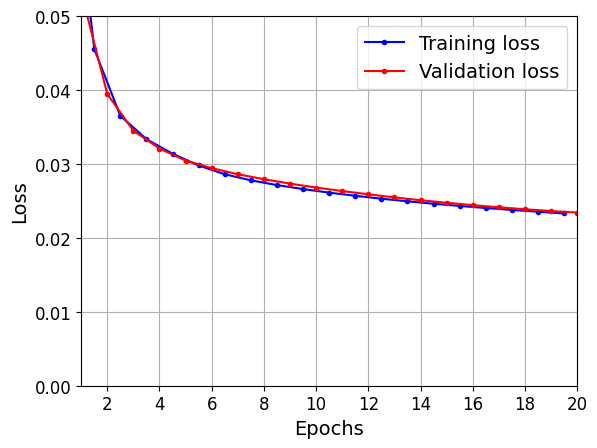

In [46]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [47]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


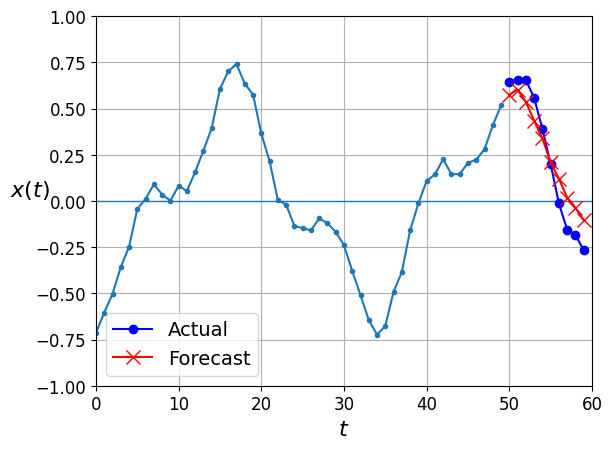

In [48]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### GRUs

In [49]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.GRU(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.GRU(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train,epochs=20,
                    validation_data=[X_valid,Y_valid])

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - last_time_step_mse: 0.0971 - loss: 0.1029 - val_last_time_step_mse: 0.0436 - val_loss: 0.0548
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - last_time_step_mse: 0.0419 - loss: 0.0520 - val_last_time_step_mse: 0.0342 - val_loss: 0.0457
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - last_time_step_mse: 0.0344 - loss: 0.0448 - val_last_time_step_mse: 0.0295 - val_loss: 0.0415
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - last_time_step_mse: 0.0302 - loss: 0.0410 - val_last_time_step_mse: 0.0249 - val_loss: 0.0376
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - last_time_step_mse: 0.0260 - loss: 0.0369 - val_last_time_step_mse: 0.0224 - val_loss: 0.0339
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - last_time_step_mse: 0.0225 - loss: 0.0338 - val_last_time_step_mse: 0.0195 - val_loss: 0.0316
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - last_time_step_mse: 0.0198 - loss: 0.0317 - 

In [50]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - last_time_step_mse: 0.0102 - loss: 0.0235


[0.02350473590195179, 0.010100646875798702]

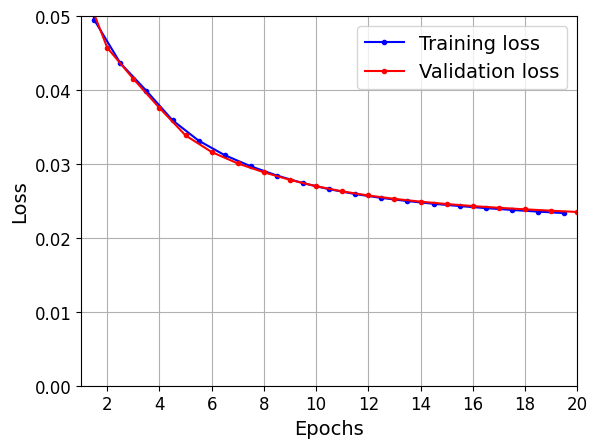

In [51]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [52]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


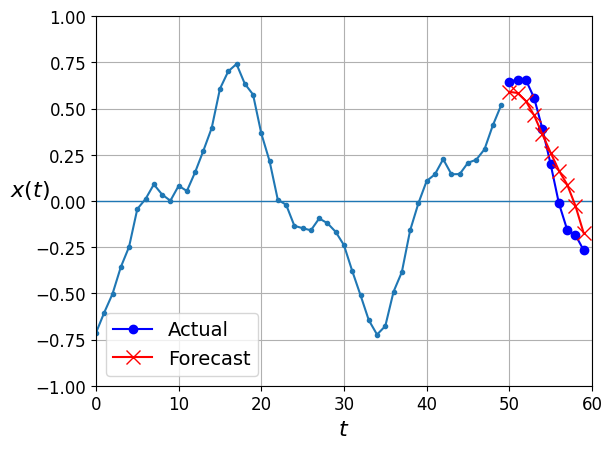

In [53]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### Using One-Dimensional Convolutiional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - last_time_step_mse: 0.0940 - loss: 0.0997 - val_last_time_step_mse: 0.0386 - val_loss: 0.0477
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - last_time_step_mse: 0.0355 - loss: 0.0435 - val_last_time_step_mse: 0.0271 - val_loss: 0.0364
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - last_time_step_mse: 0.0271 - loss: 0.0351 - val_last_time_step_mse: 0.0206 - val_loss: 0.0314
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - last_time_step_mse: 0.0202 - loss: 0.0301 - val_last_time_step_mse: 0.0163 - val_loss: 0.0277
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - last_time_step_mse: 0.0160 - loss: 0.0268 - val_last_time_step_mse: 0.0141 - val_loss: 0.0253
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - last_time_step_mse: 0.0140 - loss: 0.0250 - val_last_time_step_mse: 0.0128 - val_loss: 0.0240
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - last_time_step_mse: 0.0127 - loss: 0.0238 - val_

### Wavenet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```


In [55]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - last_time_step_mse: 0.0872 - loss: 0.0964 - val_last_time_step_mse: 0.0232 - val_loss: 0.0366
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0221 - loss: 0.0342 - val_last_time_step_mse: 0.0184 - val_loss: 0.0302
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0177 - loss: 0.0292 - val_last_time_step_mse: 0.0167 - val_loss: 0.0281
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0159 - loss: 0.0273 - val_last_time_step_mse: 0.0151 - val_loss: 0.0265
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0147 - loss: 0.0260 - val_last_time_step_mse: 0.0143 - val_loss: 0.0256
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0138 - loss: 0.0251 - val_last_time_step_mse: 0.0136 - val_loss: 0.0249
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - last_time_step_mse: 0.0130 - loss: 0.0244 - val_last_time_step

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [56]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [57]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [58]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [59]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - last_time_step_mse: 0.1334 - loss: 0.1375 - val_last_time_step_mse: 0.1195 - val_loss: 0.1226
Epoch 2/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - last_time_step_mse: 0.1175 - loss: 0.1222 - val_last_time_step_mse: 0.1187 - val_loss: 0.1216


### Exercises

In [60]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065301781/1065301781 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [61]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path)for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [62]:
train_files

[]

In [ ]:
def find_quickdraw_tfrecords():
  DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
  FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"

  filepath = tf.keras.utils.get_file(
      FILENAME,
      DOWNLOAD_ROOT + FILENAME,
      cache_subdir = "datasets/quickdraw",
      extract=True
  )
  print(f"Download archive path:{filepath}")
  quickdraw_dir = Path(filepath).parent
  print(f"Searching in directory: {quickdraw_dir}")

    # Search for training files using the correct pattern
  train_files = sorted([
        str(path) for path in quickdraw_dir.glob("training.tfrecord-*")
    ])

    # Search for evaluation files
  eval_files = sorted([
        str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")
    ])

  for file in train_files:
        print(f"  - {Path(file).name}")

  print(f"\nTotal training files found: {len(train_files)}")
  print(f"Total evaluation files found: {len(eval_files)}")

  return train_files, eval_files
if __name__ == "__main__":
    find_quickdraw_tfrecords()
